In [14]:
import censusdis.data as ced
import censusdis.maps as cem
from censusdis.states import IL
from censusdis.counties.illinois import COOK

import divintseg as dis

## Setup

In [15]:
CENSUS_API_KEY = None
YEAR = 2020
DATASET = "dec/pl"
GROUP = "P1"

tracts_near_north = ['080100']
print(tracts_near_north)

['080100']


## Download the data for Near North

In [16]:
df_near_north = ced.download(
    dataset=DATASET,
    vintage=YEAR,
    leaves_of_group=GROUP,
    state=IL,
    county=COOK,
    tract=tracts_near_north,
    block='*',
    api_key=CENSUS_API_KEY,
)

In [17]:
df_near_north.head(10)

,STATE,COUNTY,TRACT,BLOCK,GEO_ID,NAME,P1_003N,P1_004N,P1_005N,P1_006N,...,P1_060N,P1_061N,P1_062N,P1_064N,P1_065N,P1_066N,P1_067N,P1_068N,P1_069N,P1_071N
0,17,031,080100,1000,1000000US170310801001000,"Block 1000, Block Group 1, Census Tract 801, C...",214,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,17,031,080100,1001,1000000US170310801001001,"Block 1001, Block Group 1, Census Tract 801, C...",229,3,0,28,...,0,0,0,0,0,0,0,0,0,0
2,17,031,080100,2000,1000000US170310801002000,"Block 2000, Block Group 2, Census Tract 801, C...",137,5,0,8,...,0,0,0,0,0,0,0,0,0,0
3,17,031,080100,2001,1000000US170310801002001,"Block 2001, Block Group 2, Census Tract 801, C...",125,3,2,6,...,0,0,0,0,0,0,0,0,0,0
4,17,031,080100,2002,1000000US170310801002002,"Block 2002, Block Group 2, Census Tract 801, C...",307,8,0,35,...,0,0,0,0,0,0,0,0,0,0
5,17,031,080100,2003,1000000US170310801002003,"Block 2003, Block Group 2, Census Tract 801, C...",289,0,0,6,...,0,0,0,0,0,0,0,0,0,0
6,17,031,080100,2004,1000000US170310801002004,"Block 2004, Block Group 2, Census Tract 801, C...",115,4,0,17,...,0,0,0,0,0,0,0,0,0,0
7,17,031,080100,3001,1000000US170310801003001,"Block 3001, Block Group 3, Census Tract 801, C...",100,6,0,7,...,0,0,0,0,0,0,0,0,0,0
8,17,031,080100,4000,1000000US170310801004000,"Block 4000, Block Group 4, Census Tract 801, C...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,17,031,080100,4002,1000000US170310801004002,"Block 4002, Block Group 4, Census Tract 801, C...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Compute diversity and integration

In [18]:
df_near_north_di = dis.di(
    df_communities=df_near_north,
    by=['STATE', 'COUNTY', 'TRACT'], 
    over='BLOCK'
).reset_index()

df_near_north_di.head(10)

c:\Users\bcong\Dropbox\github\near-north-demographics\.venv\Lib\site-packages\divintseg\_core.py:169: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_communities.groupby(by=by).apply(integration_of_group),


,STATE,COUNTY,TRACT,diversity,integration
0,17,031,080100,0.27369,0.269444


## Plot

In [19]:
df_near_north_di = ced.add_inferred_geography(df_near_north_di, YEAR)

In [20]:
df_near_north_di.head(10)

,STATE,COUNTY,TRACT,diversity,integration,geometry
0,17,031,080100,0.27369,0.269444,"POLYGON ((-87.62889 41.91122, -87.62573 41.911..."


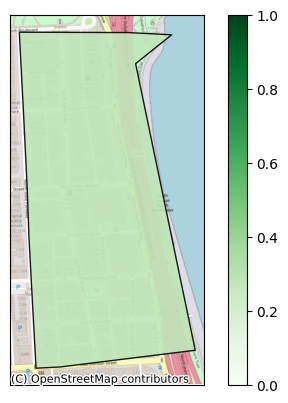

In [ ]:
ax = cem.plot_map(
    df_near_north_di,
    "diversity",
    cmap="Greens",
    edgecolor="black",
    alpha=0.5,
    with_background=True,
    legend=True,
    vmin=0.0,
    vmax=1.0,
)